# model training

In [7]:
import argparse
import os

import matplotlib.pyplot as plt
import numpy as np
from pettingzoo.mpe import simple_world_comm_v3, simple_tag_v3

from maddpg import MADDPG
from m3ddpg import M3DDPG

In [8]:
# choose env from pettzingzoo 

def get_env(env_name, ep_len=25):
    if env_name == 'simple_tag_v3':
        new_env = simple_tag_v3.parallel_env(max_cycles=ep_len)
    elif env_name == 'simple_world_comm_v3':
        new_env = simple_world_comm_v3.parallel_env(max_cycles=ep_len) 
    new_env.reset()
    _dim_info = {}
    for agent_id in new_env.agents:
        # get dimension information of each agent,used for network training
        # [obs_dim, act_dim]
        _dim_info[agent_id] = []  
        _dim_info[agent_id].append(new_env.observation_space(agent_id).shape[0])
        _dim_info[agent_id].append(new_env.action_space(agent_id).n)

    return new_env, _dim_info


In [9]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--env_name', type=str, default='simple_tag_v3', help='name of the env')
    parser.add_argument('--episode_num', type=int, default =4000,
                        help='total episode num during training procedure')
    parser.add_argument('--episode_length', type=int, default=25, help='steps per episode')
    parser.add_argument('--learn_interval', type=int, default=100,
                        help='steps interval between learning time')
    parser.add_argument('--random_steps', type=int, default=1e3,
                        help='random steps before the agent start to learn')
    parser.add_argument('--tau', type=float, default=0.02, help='soft update parameter')
    parser.add_argument('--gamma', type=float, default=0.95, help='discount factor')
    parser.add_argument('--buffer_capacity', type=int, default=int(1e6), help='capacity of replay buffer')
    parser.add_argument('--batch_size', type=int, default=1024, help='batch-size of replay buffer')
    parser.add_argument('--actor_lr', type=float, default=0.01, help='learning rate of actor')
    parser.add_argument('--critic_lr', type=float, default=0.01, help='learning rate of critic')
    parser.add_argument('-f', help='a dummy argument to fool ipython', default='1')
   
    args = parser.parse_args()

In [10]:
# create folder to save result
env_dir = os.path.join('./results', args.env_name)
if not os.path.exists(env_dir):
    os.makedirs(env_dir)
total_files = len([file for file in os.listdir(env_dir)])
result_dir = os.path.join(env_dir, f'{total_files + 1}')
os.makedirs(result_dir)

In [11]:
# train 
env, dim_info = get_env(args.env_name, args.episode_length)
maddpg = MADDPG(dim_info, args.buffer_capacity, args.batch_size, args.actor_lr, args.critic_lr,
                    result_dir)
step = 0  # global step counter
agent_num = env.num_agents
# reward of each episode of each agent
episode_rewards = {agent_id: np.zeros(args.episode_num) for agent_id in env.agents}
for episode in range(args.episode_num):
    obs,_ = env.reset()
    agent_reward = {agent_id: 0 for agent_id in env.agents}  # agent reward of the current episode
    while env.agents:  
         # interact with the env for an episode
        step += 1
        # some exploration
        if step < args.random_steps:
            action = {agent_id: env.action_space(agent_id).sample() for agent_id in env.agents}
        else:
        # select action by policy
            action = maddpg.select_action(obs)
        
        next_obs, reward, done,_, info = env.step(action)

        maddpg.add_to_buffer(obs, action, reward, next_obs, done)

        # update gross reward
        for agent_id, r in reward.items(): 
            agent_reward[agent_id] += r
        # update parameter every specific steps
        if step >= args.random_steps and step % args.learn_interval == 0: 
            maddpg.learn(args.gamma)
            maddpg.update_target(args.tau)

        obs = next_obs

    # episode finishes
    for agent_id, r in agent_reward.items():  # record reward
        episode_rewards[agent_id][episode] = r

    if (episode + 1) % 100 == 0:  # print info every 100 episodes
        message = f'episode {episode + 1}, '
        sum_reward = 0
        for agent_id, r in agent_reward.items():  # record reward
            message += f'{agent_id}: {r:>4f}; '
            sum_reward += r
        message += f'sum reward: {sum_reward}'
        print(message)

maddpg.save(episode_rewards)  # save model


def get_running_reward(arr: np.ndarray, window=100):
    """calculate the running reward, i.e. average of last `window` elements from rewards"""
    running_reward = np.zeros_like(arr)
    for i in range(window - 1):
        running_reward[i] = np.mean(arr[:i + 1])
    for i in range(window - 1, len(arr)):
        running_reward[i] = np.mean(arr[i - window + 1:i + 1])
    return running_reward




episode 100, adversary_0: 0.000000; adversary_1: 0.000000; adversary_2: 0.000000; agent_0: -11.373863; sum reward: -11.373862633219616
episode 200, adversary_0: 0.000000; adversary_1: 0.000000; adversary_2: 0.000000; agent_0: -96.039332; sum reward: -96.03933236952572
episode 300, adversary_0: 0.000000; adversary_1: 0.000000; adversary_2: 0.000000; agent_0: -66.881969; sum reward: -66.88196858389549
episode 400, adversary_0: 0.000000; adversary_1: 0.000000; adversary_2: 0.000000; agent_0: -154.595793; sum reward: -154.59579275313243
episode 500, adversary_0: 0.000000; adversary_1: 0.000000; adversary_2: 0.000000; agent_0: -0.455639; sum reward: -0.4556390737477911
episode 600, adversary_0: 0.000000; adversary_1: 0.000000; adversary_2: 0.000000; agent_0: -110.875592; sum reward: -110.87559248155247
episode 700, adversary_0: 0.000000; adversary_1: 0.000000; adversary_2: 0.000000; agent_0: -42.057571; sum reward: -42.05757102177528
episode 800, adversary_0: 0.000000; adversary_1: 0.000000

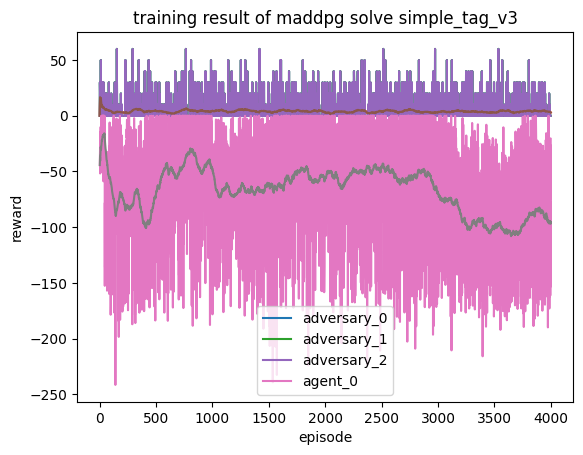

In [12]:
# training finishes, plot reward
fig, ax = plt.subplots()
x = range(1, args.episode_num + 1)
for agent_id, reward in episode_rewards.items():
    ax.plot(x, reward, label=agent_id)
    ax.plot(x, get_running_reward(reward))
ax.legend()
ax.set_xlabel('episode')
ax.set_ylabel('reward')
title = f'training result of maddpg solve {args.env_name}'
ax.set_title(title)
plt.savefig(os.path.join(result_dir, title))
